# Sommaire <a name=0 ></a>
- [Introduction](#1)
- [I. Simulation d'Autres Modèles & Choix d'un Modèle Final](#2)
- [II. Analyse de la "Feature Importance" Globale & Locale](#3)
- [III. Analyse de l'Influence de l'EnergyStarScore](#4)
- [IV. Amélioration du Feature Engineering](#5)
- [V. Conclusion](#5)

# Introduction<a name=1 ></a>

Dans notre précédent notebook, nous nous sommes chargés de préparer notre base de données dans le but de pouvoir produire des modèles de prédiction en se basant dessus. A partir de cette dernière, nous avons ainsi procédé à un nettoyage des données à la fois par approche métier et par des méthodes statistiques, tout en effectuant en parallèle une brève analyse exploratoire, le tout en ayant sélectionné un groupe de variables constituant nos features et démarrer une première série de feature engineering.

A ce stade de notre étude, nous avons pratiqué toutes les opérations permettant la création d'une base de données solide et sommes apte à la modéliser dans le but de prédire nos variables cibles. Dans cette démarche, nous avions également conçu notre premier modèle de prédiction par régression linéaire, aboutissant à des résultats plus que mitigés mais pouvant nous servir de base d'amélioration.

Le notebook ci-présent consistera donc à effectuer la suite des étapes de notre projet en se focalisant sur la variable cible "TotalGHGEmissions", représentant la quantité de gaz à effet de serre émis par chacun des individus présents dans notre base de données.

Dans un premier temps, nous allons donc comparer les performances de différents modèles afin d'effectuer un choix définitif sur celui à adopter. Notre modèle de prédiction final choisi, nous allons nous intéresser à l'impact qu'exerce chacune de nos features sur ladite performance. Nous allons notamment nous intéresser de très près à la variable "EnergyStarScore". L'Energy Star Score est une mesure fastidieuse à calculer avec l'approche utilisée actuellement par notre équipe. L'enjeu ici est donc de l'intégrer dans la modélisation et de juger de son intérêt.

Selon les résultats de notre analyse de la "feature importance" globale et locale, nous jugerons de la nécessité d'améliorer notre feature engineering et ferons les modifications en fonction. Enfin, une fois notre feature engineering améliorée et notre modèle de prédiction finale paramétrée, nous établirons une conclusion de nos recherches.


# I. Simulation d'Autres Modèles & Choix d'un Modèle Final<a name=2 ></a>

Avant toute chose, nous allons récupérer l'ensemble des modifications qui ont été faites dans le précédent notebook de sorte de pouvoir reprendre exactement là où on en était. 

Nous allons donc de nouveau charger les données du fichier CSV "2016_Building_Energy_Benchmarking.csv", puis nous allons nettoyer et transformer les données exactement comme fait précédemment en concentrant l'ensemble de ces manipulation en une fonction Python que l'on nommera "pretreatment". Enfin, nous n'oublierons pas de diviser nos données en variable cible et en variables explicatives.

A partir de là, contrairement précédemment, les travaux de transformation des données pour les rendre modélisables seront appliquées ici au préalable par la création d'une Pipeline. Les variables numériques demeurent mises à l'échelle à l'aide de StandardScaler, tandis que la variable catégorielle "PrimaryPropertyType" demeure encodée en utilisant OneHotEncoder.

Ensuite, une deuxième pipeline sera créé pour combiner le prétraitement et le modèle de régression linéaire. Ce pipeline facilitera in fine l'application cohérente des transformations et du modèle sur les données. Ici nous testons de nouveau le modèle de régression linéaire dans le seul but de s'assurer que l'ensemble des opérations précédentes ont été effectuées proprement :

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Building_Energy_Benchmarking = pd.read_csv('2016_Building_Energy_Benchmarking.csv',dtype={'OSEBuildingID': str,'ZipCode':str})

def pretreatment(X):
    X = X.set_index('OSEBuildingID')
    non_residential = ['NonResidential','SPS-District K-12','Nonresidential COS','Campus','Nonresidential WA']
    X = X.loc[X['BuildingType'].isin(non_residential)]
    X.drop(X[X['ComplianceStatus']!='Compliant'].index, inplace=True)
    X.loc[X['NumberofBuildings'] == 0,'NumberofBuildings'] = 1
    X.drop(X[(X[['TotalGHGEmissions','SiteEnergyUseWN(kBtu)']] <= 0).any(axis=1)].index, inplace=True)
    X.drop(X[(X[['TotalGHGEmissions','SiteEnergyUseWN(kBtu)']].isna()).any(axis=1)].index, inplace=True)
    X.drop(X[X['Electricity(kBtu)'] <= 0].index,inplace=True)
    X.drop(X[X['PrimaryPropertyType']=='Low-Rise Multifamily'].index,inplace=True)
    X['Neighborhood'].replace({'North': 'NORTH', 'Ballard': 'BALLARD','Central':'CENTRAL','Northwest':'NORTHWEST',
                                   'Delridge':'DELRIDGE','DELRIDGE NEIGHBORHOODS':'DELRIDGE'}, inplace=True)
    X = X[['PrimaryPropertyType','LargestPropertyUseType','LargestPropertyUseTypeGFA','SecondLargestPropertyUseType',
           'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA','PropertyName',
           'Neighborhood','Latitude','Longitude','NumberofBuildings','NumberofFloors','PropertyGFAParking','DataYear',
           'PropertyGFATotal','YearBuilt','PropertyGFABuilding(s)','Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)',
           'SiteEnergyUse(kBtu)','ENERGYSTARScore','TotalGHGEmissions','SiteEnergyUseWN(kBtu)']]
    X['Age']=X['DataYear']-X['YearBuilt']
    X["Electricity(%)"] = round(X['Electricity(kBtu)']/X['SiteEnergyUse(kBtu)']*100,2)
    X["NaturalGas(%)"] = round(X['NaturalGas(kBtu)']/X['SiteEnergyUse(kBtu)']*100,2)
    X["SteamUse(%)"] = round(X['SteamUse(kBtu)']/X['SiteEnergyUse(kBtu)']*100,2)
    X = X.drop(['PropertyName','Neighborhood','DataYear','YearBuilt',
                'Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)','SiteEnergyUse(kBtu)'], axis=1)
    X.loc[X['NumberofBuildings'] == 0,'NumberofBuildings'] = 1
    X.loc[X['NumberofFloors']==99,'NumberofFloors']=1
    return X

y = pretreatment(Building_Energy_Benchmarking)['TotalGHGEmissions']
X = pretreatment(Building_Energy_Benchmarking).drop(columns=['TotalGHGEmissions','LargestPropertyUseType','PropertyGFATotal',
                                                             'LargestPropertyUseTypeGFA','SecondLargestPropertyUseType',
                                                             'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType',
                                                             'ThirdLargestPropertyUseTypeGFA','SiteEnergyUseWN(kBtu)',
                                                             'ENERGYSTARScore'])

elements = [col for col in X.columns if X[col].dtype != object]

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, elements),
                                               ('cat', categorical_transformer, ['PrimaryPropertyType'])])

clf = Pipeline(steps=[("preprocessor", preprocessor), ("model", LinearRegression())])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=50)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("R² =", r2_score(y_test, y_pred))
print("MAE =", mean_absolute_error(y_test, y_pred))
print("RMSE =", mean_squared_error(y_test, y_pred, squared=False))

R² = -0.022618562050676028
MAE = 158.16198676331985
RMSE = 344.5810144118988


Nous voyons que les résultats sont similaires à ceux du notebook précédent. Nous sommes ainsi parvenus à effectuer toutes les étapes précédemment calibrées sans le moindre accroc, et pouvons donc passer à la prochaine étape.

Pour cette dernière, nous avons besoin de recourir à la technique du Grid Search CV (Cross-Validation). Il s'agit là d'une technique utilisée pour rechercher de manière systématique les meilleurs hyperparamètres pour un modèle d'apprentissage automatique.

- Tout d'abord, Grid Search CV explore un ensemble d'hyperparamètres dont nous ferons la prédéfinition pour une série de modèles donné. Là aussi nous prédéfinirons une série de modèles que nous souhaitons tester sur notre base de données. Ces hyperparamètres sont spécifiés sous forme de grille, où chaque dimension de la grille représente une hyperparamètre et chaque point de la grille correspond à une combinaison unique d'hyperparamètres.
- Pour chaque combinaison d'hyperparamètres de la grille, Grid Search CV utilise la validation croisée pour évaluer les performances du modèle. Cela implique de diviser les données en ensembles d'entraînement et de validation, d'entraîner le modèle sur l'ensemble d'entraînement, puis de l'évaluer sur l'ensemble de validation, comme nous l'avions vu précédemment.
- Ici nous nous servirons de la métrique RMSE pour mesurer les performances de chaque modèle sur chaque combinaison d'hyperparamètres. La légitimité du choix de cette métrique avait été donnée dans le précédent notebook.
- Une fois que toutes les combinaisons d'hyperparamètres ont été évaluées, Grid Search CV identifie les hyperparamètres qui produisent les meilleures performances du modèle.
- Une fois les meilleurs hyperparamètres identifiés, le modèle est entraîné sur l'ensemble complet des données avec ces hyperparamètres pour obtenir le modèle final.

Concernant les modèles choisis, nous avons décidé de comparer les modèles suivants : 
- Lasso Regression : technique de régression linéaire qui ajoute une pénalité L1 (norme L1) à la fonction de perte, ce qui favorise les solutions parcimonieuses en forçant les coefficients des caractéristiques moins importantes à être exactement zéro. Cela permet à Lasso Regression de sélectionner automatiquement un sous-ensemble des caractéristiques les plus importantes et de les inclure dans le modèle.
- Ridge Regression : similaire à Lasso Regression, mais utilise une pénalité L2 (norme L2) plutôt qu'une pénalité L1. Cela permet à Ridge Regression de régulariser les coefficients en les maintenant petits plutôt que de les réduire à zéro. Cette régularisation réduit le risque de surajustement en introduisant un biais dans les coefficients.
- Random Forest Regression : algorithme d'apprentissage par ensemble qui construit plusieurs arbres de décision indépendants et les combine pour obtenir des prédictions plus précises et robustes. Chaque arbre de décision est formé sur un échantillon aléatoire des données d'entraînement, et les prédictions finales sont obtenues en moyennant les prédictions de tous les arbres.
- Gradient Boosting Regression : méthode d'apprentissage par ensemble qui construit un modèle de prédiction en ajoutant séquentiellement des modèles de faible performance, appelés arbres de décision faibles, pour corriger les erreurs des modèles précédents. Il utilise le gradient de la fonction de perte pour minimiser l'erreur résiduelle à chaque étape.
- Bagging Regression : méthode d'apprentissage par ensemble qui construit plusieurs modèles de prédiction indépendants à partir de sous-ensembles aléatoires des données d'entraînement, puis combine les prédictions de ces modèles pour obtenir une prédiction finale. Cela permet de réduire la variance et d'améliorer la précision des prédictions.
- Support Vector Machine (SVM) : modèle d'apprentissage supervisé utilisé pour la classification et la régression. En régression, SVM cherche à trouver la fonction qui prédit les valeurs cibles en maximisant la marge entre les points de données et la fonction de décision. Il utilise des vecteurs de support pour déterminer la fonction de prédiction optimale.
- Transformed Target Regression : technique qui consiste à appliquer une transformation mathématique aux valeurs cibles avant d'entraîner le modèle de régression. Cela peut être utile lorsque les valeurs cibles présentent une distribution asymétrique ou des écarts importants entre les valeurs. Après la prédiction, une transformation inverse est appliquée aux prédictions pour obtenir les valeurs finales.
- Stacking Regression : méthode d'apprentissage par ensemble qui combine plusieurs modèles de prédiction de différentes classes (par exemple, régression linéaire, arbres de décision, SVM) en utilisant un modèle méta-learner pour agréger leurs prédictions. Les prédictions de chaque modèle de base sont utilisées comme caractéristiques d'entrée pour le modèle méta-learner, qui produit ensuite la prédiction finale.

In [2]:
import numpy as np
from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

base_models = [('tree', DecisionTreeRegressor(random_state=42)),('ridge', RidgeCV())]

models = [('Linear Regression', LinearRegression()),('Lasso Regression', Lasso()),('Ridge Regression', Ridge()),
          ('Random Forest Regression', RandomForestRegressor()),
          ('Gradient Boosting Regression', GradientBoostingRegressor(learning_rate=0.1)),
          ('Bagging Regression', BaggingRegressor(estimator=LinearRegression())),('Support Vector Machine', SVR()),
          ('Transformed Target Regression', TransformedTargetRegressor(regressor=LinearRegression(),func=np.log1p,
                                                                       inverse_func=np.expm1)),
          ('Stacking Regression', StackingRegressor(estimators=base_models, final_estimator=RidgeCV()))]

param_grids = [{'model__fit_intercept': [True, False]},{'model__alpha': [0.1, 1, 10]},{'model__alpha': [0.1, 1, 10]},
               {'model__n_estimators': [50, 100, 200]},{'model__n_estimators': [50, 100, 200]},
               {'model__n_estimators': [50, 100, 200]},{'model__C': [0.1, 1, 10]},{},{},{}]

results = []

for (name, model), param_grid in zip(models, param_grids):
    pipe = Pipeline([('preprocessor', preprocessor),('model', model)])
    grid_search = GridSearchCV(pipe, param_grid, cv=4, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_score = -grid_search.best_score_
    search_score = -grid_search.score(X_test, y_test)
    results.append({'Model': name,'Best RMSE Parameters': grid_search.best_params_,'Training RMSE': (best_score**0.5),
                    'Test RMSE': (search_score**0.5)})

pd.DataFrame(results)

C:\Users\Alex-\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+06, tolerance: 7.316e+04
  model = cd_fast.enet_coordinate_descent(


,Model,Best RMSE Parameters,Training RMSE,Test RMSE
0,Linear Regression,{'model__fit_intercept': False},595.862249,344.581014
1,Lasso Regression,{'model__alpha': 0.1},595.726800,344.368274
2,Ridge Regression,{'model__alpha': 0.1},595.875446,343.476907
3,Random Forest Regression,{'model__n_estimators': 100},608.243949,222.757665
4,Gradient Boosting Regression,{'model__n_estimators': 200},675.718032,223.438490
5,Bagging Regression,{'model__n_estimators': 100},596.812665,339.524319
6,Support Vector Machine,{'model__C': 10},793.201118,317.762845
7,Transformed Target Regression,{},17313.424339,545.881754
8,Stacking Regression,{},622.503355,321.089267


D'après les résultats de notre tableau, voici ce que l'on peut observer : 
- Linear Regression : Bien que le modèle de régression linéaire ait un RMSE d'entraînement relativement élevé, il généralise bien sur les données de test, avec un RMSE plus bas. Cela suggère que le modèle ne souffre pas de surajustement et est capable de généraliser correctement.
- Lasso Regression et Ridge Regression : Les deux modèles de régression avec régularisation L1 (Lasso) et L2 (Ridge) présentent de meilleures performances que la régression linéaire standard, avec des RMSE de test plus bas. Cela confirme l'efficacité de la régularisation pour améliorer la généralisation du modèle.
- Random Forest Regression et Bagging Regression : Ces modèles d'apprentissage par ensemble obtiennent les meilleurs scores de RMSE sur les données de test, ce qui suggère qu'ils ont capturé des relations complexes entre les variables et ont une meilleure capacité à généraliser sur de nouvelles données.
- Gradient Boosting Regression : Bien que ce modèle ait un RMSE d'entraînement relativement élevé, il obtient un bon RMSE sur les données de test, ce qui indique qu'il peut bien généraliser sur de nouvelles données malgré un possible surajustement.
- Support Vector Machine (SVM) : Ce modèle présente un RMSE de test relativement élevé par rapport aux autres modèles, ce qui suggère qu'il pourrait ne pas être le meilleur choix pour ce jeu de données spécifique.
- Transformed Target Regression : Ce modèle présente un RMSE d'entraînement très élevé, ce qui indique qu'il ne parvient pas à capturer efficacement la relation entre les variables d'entrée et les cibles. Le RMSE de test est également élevé, ce qui confirme que ce modèle ne généralise pas bien sur de nouvelles données.
- Stacking Regression : Ce modèle combine plusieurs modèles de régression pour obtenir des prédictions plus précises. Bien qu'il ait un RMSE d'entraînement relativement élevé, il obtient un bon RMSE sur les données de test, ce qui suggère une bonne capacité à généraliser sur de nouvelles données.

Dans l'ensemble, mise à part le modèle de Transformed Target Regression, les modèles sélectionnés semblent indiquer des performances, à des degrés variables, supérieures au modèle de régression linéaire de départ, du moins avec une configuration optimale des hyperparamètres. Nous pouvons interpréter cela comme des signes encourageants pour poursuivre notre étude.

Pour autant, nous avons ici configurer nos hyperparamètres en les limitant à 3 cas de figures. Il serait possible d'obtenir des modèles encore plus performants si l'on connaissait, pous chacun des modèles, les paramétrages idéaux. Dans cette démarche, il serait judicieux de calculer les RMSE de nos modèles en fonction du nombre d'alphas ou d'estimateurs.

Dans la partie qui va suivre, nous allons effectuer une série d'opérations qui iront dans ce sens. L'ensemble des RMSE calculés vont nous permettre la création d'un graphique dans lequel nous pourrons suivre l'évolution des chiffres entre chaque modèle selon l'hyperparamétrage qui a été opéré. Nous allons tout de même prendre en compte les hyperparamètres de notre Grid Search CV comme suit : 

In [3]:
baseline_error = mean_squared_error(y_test, clf.predict(X_test), squared=True)

n_alphas = 50
alphas = np.logspace(-5, 5, n_alphas)

Ridge_errors = []
Lasso_errors = []
SVM_errors = []

for a in alphas:
    ridge = Pipeline(steps=[("preprocessor", preprocessor), ("model", Ridge(alpha=a))])
    ridge.fit(X_train, y_train)
    Ridge_errors.append([baseline_error,mean_squared_error(y_test, ridge.predict(X_test),squared=True)])
    lasso = Pipeline(steps=[("preprocessor", preprocessor), ("model", Lasso(alpha=a))])
    lasso.fit(X_train, y_train)
    Lasso_errors.append([mean_squared_error(y_test, lasso.predict(X_test),squared=True)])
    SVM = Pipeline(steps=[("preprocessor", preprocessor), ("model", SVR(C=a))])
    SVM.fit(X_train, y_train)
    SVM_errors.append([mean_squared_error(y_test, SVM.predict(X_test),squared=True)])
    
estimators = np.arange(1, 150)

rfr_errors = []
gbr_errors = []
br_errors = []

for a in estimators:
    rfr = Pipeline(steps=[("preprocessor", preprocessor), ("model", RandomForestRegressor(n_estimators=a))])
    rfr.fit(X_train, y_train)
    rfr_errors.append([baseline_error,mean_squared_error(y_test, rfr.predict(X_test),squared=True)])
    gbr = Pipeline(steps=[("preprocessor", preprocessor), ("model", GradientBoostingRegressor(learning_rate=0.1,
                                                                                              n_estimators=a))])
    gbr.fit(X_train, y_train)
    gbr_errors.append([mean_squared_error(y_test, gbr.predict(X_test),squared=True)])
    br = Pipeline(steps=[("preprocessor", preprocessor), ("model", BaggingRegressor(estimator=LinearRegression(),
                                                                                    n_estimators=a))])
    br.fit(X_train, y_train)
    br_errors.append([mean_squared_error(y_test, br.predict(X_test),squared=True)])

C:\Users\Alex-\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+07, tolerance: 7.821e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Alex-\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+07, tolerance: 7.821e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Alex-\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+07, toleranc

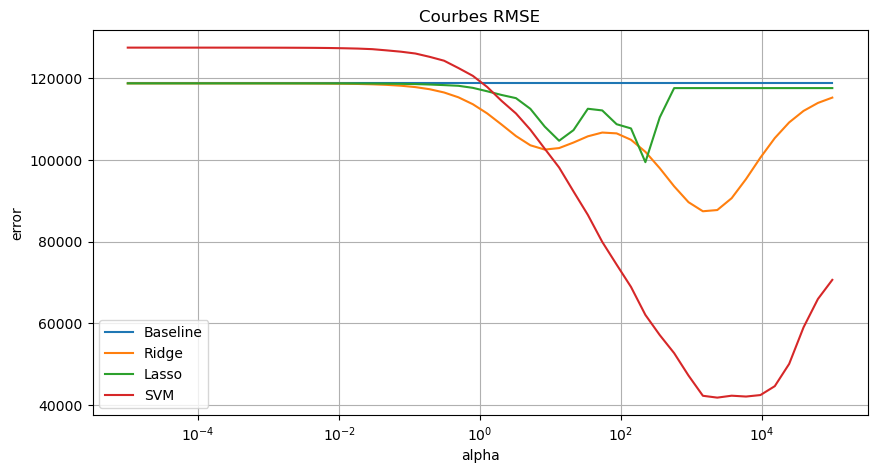

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(alphas, [t[0] for t in Ridge_errors], label='Baseline')
plt.plot(alphas, [t[1] for t in Ridge_errors], label='Ridge')
plt.plot(alphas, Lasso_errors, label='Lasso')
plt.plot(alphas, SVM_errors, label='SVM')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.title("Courbes RMSE")
plt.legend()
plt.grid()
plt.show()

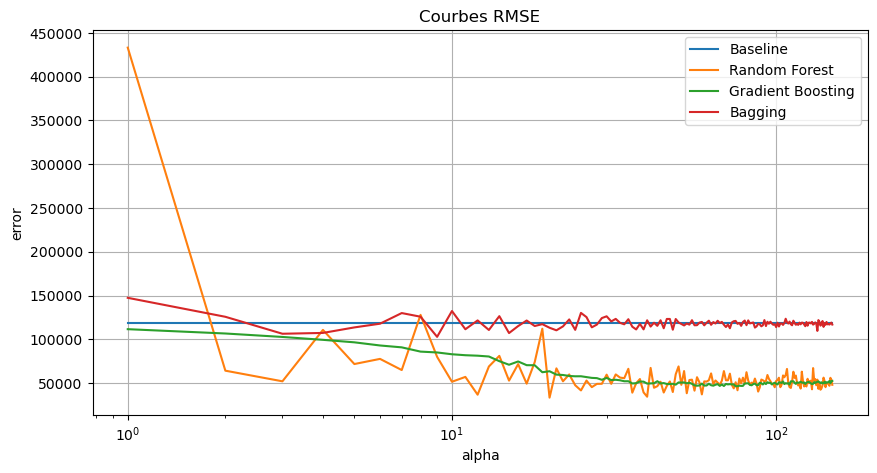

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(estimators, [t[0] for t in rfr_errors], label='Baseline')
plt.plot(estimators, [t[1] for t in rfr_errors], label='Random Forest')
plt.plot(estimators, gbr_errors, label='Gradient Boosting')
plt.plot(estimators, br_errors, label='Bagging')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.title("Courbes RMSE")
plt.legend()
plt.grid()
plt.show()

Dans les graphiques ci-dessus, nous nous sommes servis de la RMSE du modèle de régression linéaire comme baseline afin de comparer l'évolution des erreurs de chacun des modèles. Nous pouvons observer clairement la manière dont fonctionne chaque modèle et les différences de performances peuvent être extrêmement significatives en fonction de la configuration des hyperparamètres selon lesdits modèles.

Par exemple, sans avoir à faire davantage de calculs, nous pouvons déduire sans le moindre doute la pertinence du choix du modèle Support Vector Machine par rapport à ceux de Ridge et Lasso.
Vis-à-vis du deuxième graphique, il peut être plus compliqué à interpréter tel quel. Si la méthode des Forêt Aléatoires (Random Forest) présente des niveaux de performances plus élevées dans l'ensemble, ses résultats sont particulièrement inconstants selon son paramétrage, là où la méthode du Gradient Boosting offre des résultats moins performants mais plus stables, parfois même dépassant celui du Random Forest.

Quoi qu'il en soit, après avoir effectué l'ensemble de ces calculs, nous pouvons, pour chacun des modèles, extraire le paramétrage permettant l'indice de performance le plus élevé possible. Dans la prochaine étape, ces paramétrages vont être implémentés dans un nouveau Grid Search CV. Nous serons alors en mesure d'effectuer notre sélection finale, c'est-à-dire de choisir qui, parmi nos modèles aux hyperparamètres optimisés, nous donnera le meilleur résultat en termes de valeurs prédites : 

In [6]:
param_grids = [{'model__fit_intercept': [True, False]},{'model__alpha': [alphas[np.argmin(Lasso_errors)]]},
               {'model__alpha': [alphas[np.argmin([t[1] for t in Ridge_errors])]]},
               {'model__n_estimators': [estimators[np.argmin([t[1] for t in rfr_errors])]]},
               {'model__n_estimators': [estimators[np.argmin(gbr_errors)]]},
               {'model__n_estimators': [estimators[np.argmin(br_errors)]]},{'model__C': [alphas[np.argmin(SVM_errors)]]},{},{},
               {}]

results = []

for (name, model), param_grid in zip(models, param_grids):
    pipe = Pipeline([('preprocessor', preprocessor),('model', model)])
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_score = -grid_search.best_score_
    search_score = -grid_search.score(X_test, y_test)
    results.append({'Model': name,'Best RMSE Parameters': grid_search.best_params_,'Training RMSE': (best_score**0.5),
                    'Test RMSE': (search_score**0.5)})

pd.DataFrame(results)

,Model,Best RMSE Parameters,Training RMSE,Test RMSE
0,Linear Regression,{'model__fit_intercept': True},589.470705,344.581014
1,Lasso Regression,{'model__alpha': 222.29964825261956},741.473585,315.346578
2,Ridge Regression,{'model__alpha': 1456.3484775012444},713.047331,295.680519
3,Random Forest Regression,{'model__n_estimators': 20},600.437131,218.692091
4,Gradient Boosting Regression,{'model__n_estimators': 76},595.404407,217.309606
5,Bagging Regression,{'model__n_estimators': 9},593.329643,324.472037
6,Support Vector Machine,{'model__C': 2329.951810515372},699.393990,204.460512
7,Transformed Target Regression,{},12838.331526,545.881754
8,Stacking Regression,{},598.428683,321.089267


Les modélisations avec hyperparamètres optimisés nous permettent d'observer les faits suivants : 
- Avec une augmentation du paramètre alpha, les modèles Lasso et Ridge montrent tous deux une légère amélioration du RMSE de test.
- La hausse de performance de la régression Random Forest s'explique par le surajustement des paramètres menant à une instabilité desdites performances observé graphiquement dans nos précédentes opérations.
- Bien que le modèle Gradient Boosting Regression affiche une légère amélioration du RMSE d'entraînement dans les nouveaux résultats, le RMSE de test a augmenté de manière significative.
- Le RMSE de test du modèle Bagging Regression est légèrement plus élevé dans les nouveaux résultats, malgré une légère diminution du nombre d'estimateurs.
- Le modèle SVM montre une nette amélioration de la généralisation dans les nouveaux résultats, avec une diminution significative du RMSE de test.

Dans l'ensemble, ces résultats sont encourageants car ils indiquent une amélioration de la capacité des modèles à faire des prédictions précises sur des données non vues. En outre, même si de nettes diminution du RMSE de test sont observées dans la quasi-totalité de nos modèles, il est impératif de ne choisir qu'un seul parmi eux. Si l'on oriente nos choix selon les RMSE de test, notre choix final se joue entre les modèles de Gradient Boosting Regression ou de Support Vector Machine. Dans le cas du SVM, un surajustement des prédictions est à craindre, et c'est pourquoi nous choisissons en tout et pour tout le modèle Gradient Boosting.

Avant de passer à la partie suivante, nous allons comparer, comme dans le notebook précédent, les valeurs prédites aux valeurs réelles de l'ensemble de nos individus via un scatterplot : 

R² = 0.5951553817747317
MAE = 86.53579524290012
RMSE = 216.80969305983706


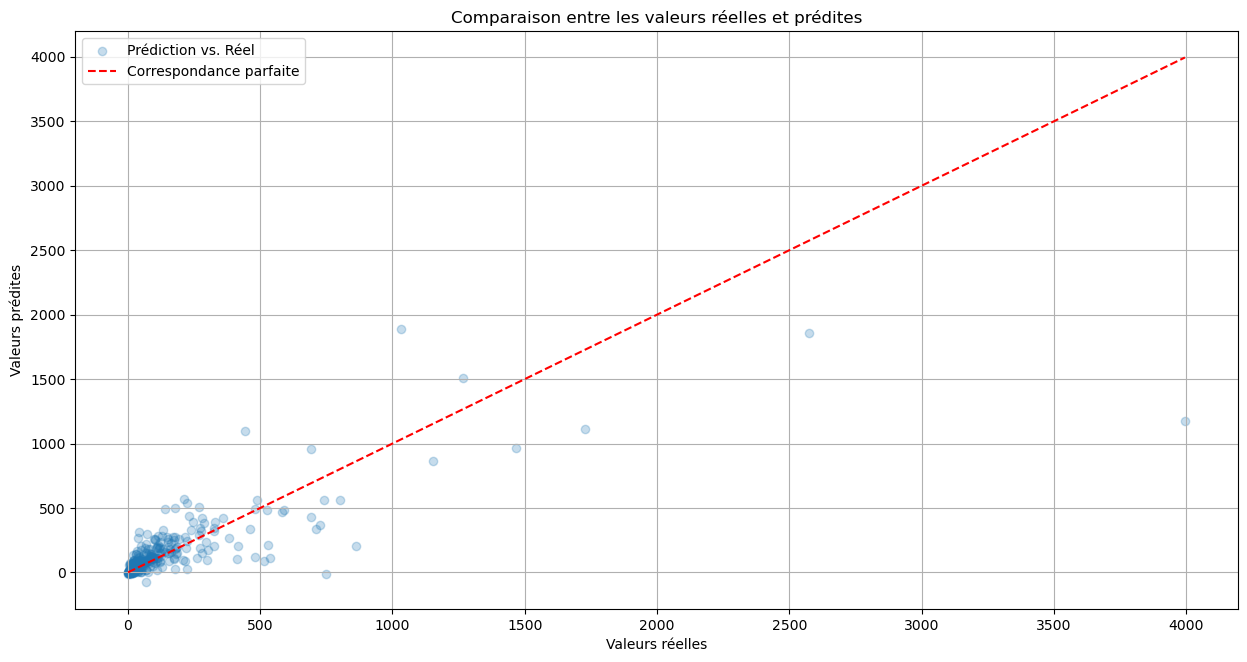

In [7]:
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators = 71)
clf = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("R² =", r2_score(y_test, y_pred))
print("MAE =", mean_absolute_error(y_test, y_pred))
print("RMSE =", mean_squared_error(y_test, y_pred, squared=False))
y_pred = pd.DataFrame(y_pred)
plt.figure(figsize=(15, 7.5))
plt.scatter(y_test, y_pred, alpha=0.25, label='Prédiction vs. Réel')
plt.plot([y_test.min(), y_test.max()],[y_test.min(),y_test.max()],color='red', linestyle='--',label='Correspondance parfaite')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison entre les valeurs réelles et prédites')
plt.legend()
plt.grid()
plt.show()

Si l'on compare le niveau de performance du modèle actuel avec celui de la Régression Linéaire de départ, la progression est nette et significative. Nous sommes donc sur la bonne voie. Pour autant, il est peut-être encore possible d'améliorer notre modèle de prédiction. Si toutes les mesures ont été faites au niveau des méthodes de modélisation, il demeure encore des axes d'amélioration potientiels dans le contenu même de notre base de données. En effet, bien qu'ayant déjà effectué une série de feature engineering, il serait judicieux d'explorer encore davantage d'options. Mais avant cela, il faut s'intéresser davantage a ce qui a été fait.

# II. Analyse de la "Feature Importance" Globale & Locale<a name=3 ></a>

L'analyse de la "feature importance" est une méthode utilisée pour évaluer l'impact de chaque caractéristique (ou variable) sur la performance d'un modèle d'apprentissage automatique. Cette analyse est particulièrement utile dans les modèles basés sur des arbres de décision et leurs dérivés, tels que les forêts aléatoires et les méthodes de boosting, mais peut également être appliquée à d'autres types de modèles.

L'idée principale derrière l'analyse de l'importance des caractéristiques est de comprendre quelles caractéristiques sont les plus influentes pour prédire la variable cible. Cela peut être crucial pour plusieurs raisons :

- Interprétabilité du modèle : Comprendre quelles caractéristiques ont le plus d'impact sur les prédictions du modèle peut fournir des informations précieuses sur la relation entre les caractéristiques d'entrée et la cible, ce qui rend le modèle plus interprétable pour les utilisateurs finaux.
- Sélection de caractéristiques : Identifier les caractéristiques les plus importantes peut aider à réduire la dimensionnalité des données en ne conservant que les caractéristiques les plus informatives, ce qui peut conduire à des modèles plus simples et plus efficaces.
- Détection de problèmes : Une analyse de l'importance des caractéristiques peut révéler des problèmes tels que des caractéristiques redondantes ou des caractéristiques non informatives qui peuvent être éliminées pour améliorer les performances du modèle.

Il s'agit donc d'une étape importante dans le processus de construction et d'interprétation des modèles d'apprentissage automatique, car elle fournit des informations sur les caractéristiques les plus influentes et contribue à une meilleure compréhension du comportement du modèle.

Pour effectuer cette analyse, nous allons avoir besoin d'un outil en particulier : Shap

In [8]:
pip install shap

La librairie SHAP (SHapley Additive exPlanations) est une bibliothèque Python conçue pour expliquer les prédictions des modèles de machine learning de manière cohérente et interprétable. Grâce à cette fonctionnalité, des explications locales et globales des modèles de machine learning peuvent être fournies en utilisant les valeurs de Shapley, un concept issu de la théorie des jeux coopératifs. Les valeurs de Shapley attribuent de manière équitable le crédit des prédictions aux différentes features (caractéristiques) du modèle, et garantissent une répartition cohérente de l'importance des features, respectant des propriétés mathématiques précises comme l'efficacité, la symétrie et l'absence d'interaction entre features non influentes.

Nous allons donc ici appliquer les valeurs de Shapley sur notre modèle optimisé, puis analyser l'importance de l'ensemble de nos variables explicatives à l'aide d'une série de graphiques, en débutant tout d'abord par une visualisation de l'importance et de l'effet de chaque feature sur les prédictions du modèle de manière globale via le graphique dit "beeswarm".

Ce graphique offre une manière visuelle et intuitive de comprendre comment chaque feature contribue aux prédictions d'un modèle. Il aide à identifier les features les plus influentes et à comprendre leurs effets directionnels, ce qui est crucial pour l'interprétation et la confiance dans les modèles : 

PermutationExplainer explainer: 1227it [01:41, 11.44it/s]                          


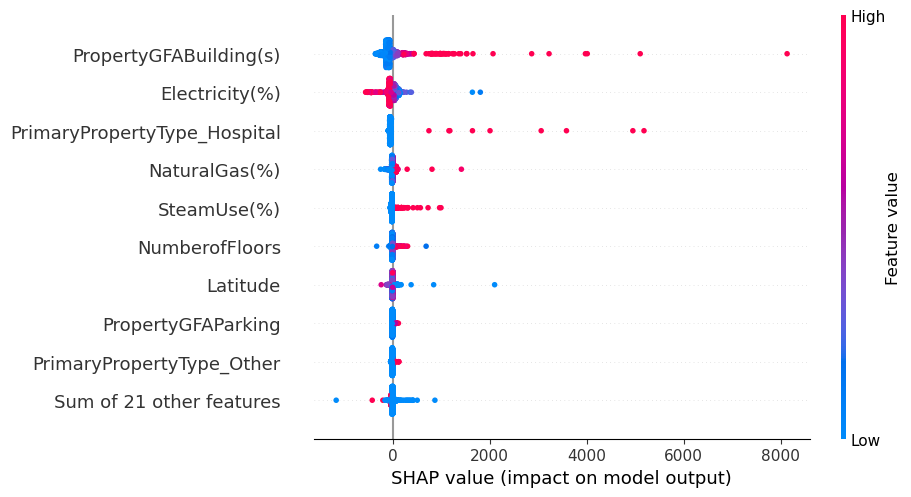

In [9]:
import shap

standardscaler = StandardScaler().fit(X_train[elements])
onehotencoder = OneHotEncoder(handle_unknown='ignore').fit(X_train[['PrimaryPropertyType']])

def preprocess(X) : 
    X_encoded = pd.DataFrame(standardscaler.transform(X[elements]), columns=elements, index=X.index)
    X_categorical = pd.DataFrame(onehotencoder.transform(X[['PrimaryPropertyType']]).toarray(),
                                 columns=onehotencoder.get_feature_names_out(['PrimaryPropertyType']))
    X_categorical.index = X.index
    return pd.concat([X_encoded, X_categorical], axis=1)

model.fit(preprocess(X_train),y_train)

explainer = shap.Explainer(model.predict, preprocess(X_train))
shap_values = explainer(preprocess(X_train))

shap.plots.beeswarm(shap_values)

Dans ce graphique, nous sommes en mesure de confirmer un ensemble d'informations présumées par l'approche métier :
- Plus la taille de la surface bâtie d'une propriété est importante, plus ladite propriété émettra une quantité de gaz à effet de serre élevé.
- Les émissions de gaz à effet de serre d'un bâtiment sera d'autant plus significativement élevé si ce dernier exerce des activités relevant du domaine hospitalier.
- Une part de consommation plus importante de gaz naturel ou de vapeur dans la consommation d'énergie globale entraînera également une émission de gaz à effet de serre plus élevée.
- Inversement, si c'est l'électricité qui est privilégiée comme mode de consommation d'énergie, la valeur de notre variable cible aura tendance à être plus faible.

Regardons maintenant les tendances que l'on peut observer à l'échelle locale grâce au graphique de cascade, ou "waterfall", de Shap.

Le waterfall plot est conçu pour décomposer et visualiser la contribution de chaque feature à une prédiction spécifique d'un modèle de machine learning. Il montre comment chaque feature influence la valeur prédite par le modèle, partant d'une base (ou valeur attendue) jusqu'à la prédiction finale : 

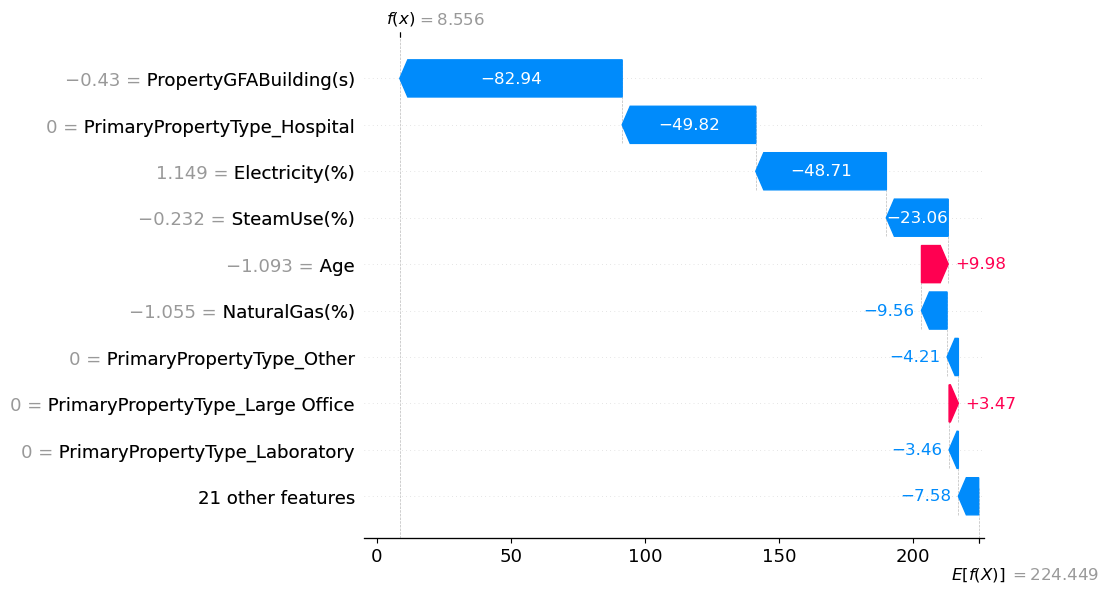

In [10]:
shap.plots.waterfall(shap_values[200], max_display=10)

Dans ce graphique, chaque barre représente la contribution d'une feature à la différence entre la valeur de base et la prédiction finale. La valeur de base, ou baseline, est typiquement la prédiction moyenne du modèle si aucune feature spécifique n'était prise en compte. Ainsi, c'est la somme de la valeur de base et des contributions des features donne la prédiction finale pour l'instance : 
- Les barres montantes en rouge indiquent une augmentation de la prédiction par rapport à la valeur de base.
- Les barres descendantes en bleu indiquent une diminution de la prédiction par rapport à la valeur de base.

Grâce aux analyses qui ont ainsi été conduites dans cette partie, nous sommes en mesure de connaître les variables cibles les plus significatives dans la performance de notre modèle de prédiction, ainsi que celles qui, au contraire, exercent un impact quasi-anecdotique sur le modèle.

Pour la suite des travaux, il nous a été demandé de mesurer, au même titre que nos précédentes variables explicatives, l'importance que peut hypothétiquement occuper la variable "EnergyStarScore", que nous avons jusqu'ici négligé de prendre en compte en raison de son taux de remplissage particulièrement faible dans notre base de données de départ. L'enjeu sera de déterminer dans laquelle des deux catégories de variable explicatives nous devons l'associer.

# III. Analyse de l'Influence de l'EnergyStarScore<a name=4 ></a>

L'Energy Star Score est une mesure de la performance énergétique d'un bâtiment par rapport à des bâtiments similaires. Son calcul est certes fastidieux, mais il constitue un outil précieux pour évaluer et améliorer l'efficacité énergétique des bâtiments. En fournissant une mesure standardisée et comparative de la performance énergétique, il aide les propriétaires et les gestionnaires de bâtiments à identifier les domaines nécessitant des améliorations, à réduire les coûts énergétiques, et à contribuer à des pratiques plus durables et respectueuses de l'environnement.

Dans notre contexte, il y a fort à parier que notre modèle de prédiction verra son niveau de performance significativement réduit en raison du nombre modeste de bâtiments dont l'Energy Star Score a été indiqué. Cela ne signifiera pas pour autant que cette variable explicative exerce un impact négatif sur les prédictions. C'est ce que nous verrons ici grâce aux même outils d'analyse de Shap dont nous nous sommes servis dans la partie précédente. Commençons d'abord par créer une nouvelle base de données qui ne conserve que les bâtiments dont l'Energy Star Score est indiqué : 

In [11]:
energy = pretreatment(Building_Energy_Benchmarking).loc[pretreatment(Building_Energy_Benchmarking)['ENERGYSTARScore'].notna()]

y = energy['TotalGHGEmissions']
X = energy.drop(columns=['TotalGHGEmissions','LargestPropertyUseType','PropertyGFATotal','LargestPropertyUseTypeGFA',
               'SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType',
               'ThirdLargestPropertyUseTypeGFA','SiteEnergyUseWN(kBtu)'])

elements = [col for col in X.columns if X[col].dtype != object]

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, elements),
                                               ('cat', categorical_transformer, ['PrimaryPropertyType'])])

clf = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=50)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("R² =", r2_score(y_test, y_pred))
print("MAE =", mean_absolute_error(y_test, y_pred))
print("RMSE =", mean_squared_error(y_test, y_pred, squared=False))

R² = 0.12410693346386614
MAE = 145.58268466561827
RMSE = 1134.7375393467828


Comme l'on pouvait s'y attendre, la réduction du nombre d'individus à étudier de quasiment 25% a négativement impacté notre modélisation. Cependant, ce n'est pas ici ce qui nous intéresse. Nous allons donc recourir aux même outils que dans la partie précédente et conclure l'actuelle par une interprétation des résultats observées dans les graphiques : 

PermutationExplainer explainer: 790it [00:54, 11.58it/s]                         


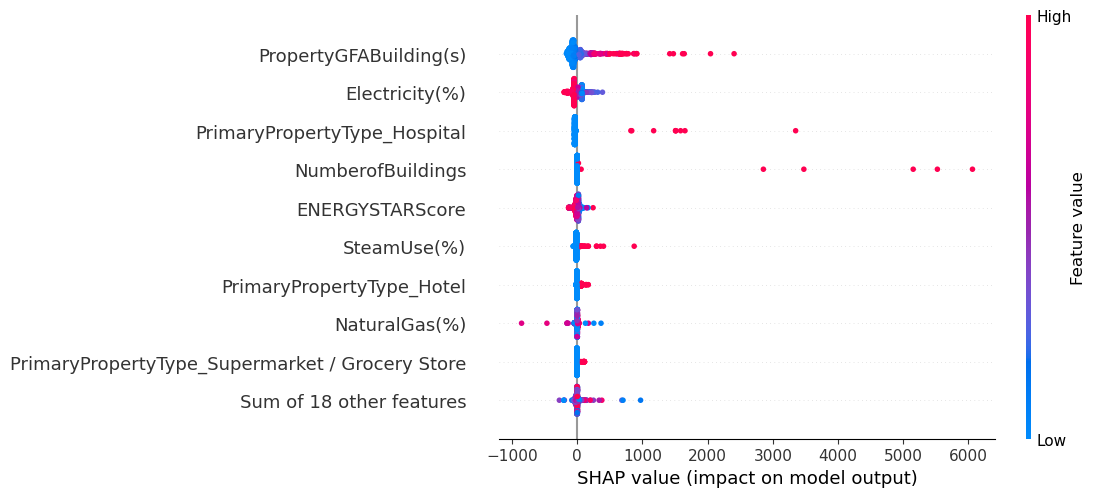

In [12]:
standardscaler = StandardScaler().fit(X_train[elements])
onehotencoder = OneHotEncoder(handle_unknown='ignore').fit(X_train[['PrimaryPropertyType']])

model.fit(preprocess(X_train),y_train)

explainer = shap.Explainer(model.predict, preprocess(X_train))
shap_values = explainer(preprocess(X_train))

shap.plots.beeswarm(shap_values)

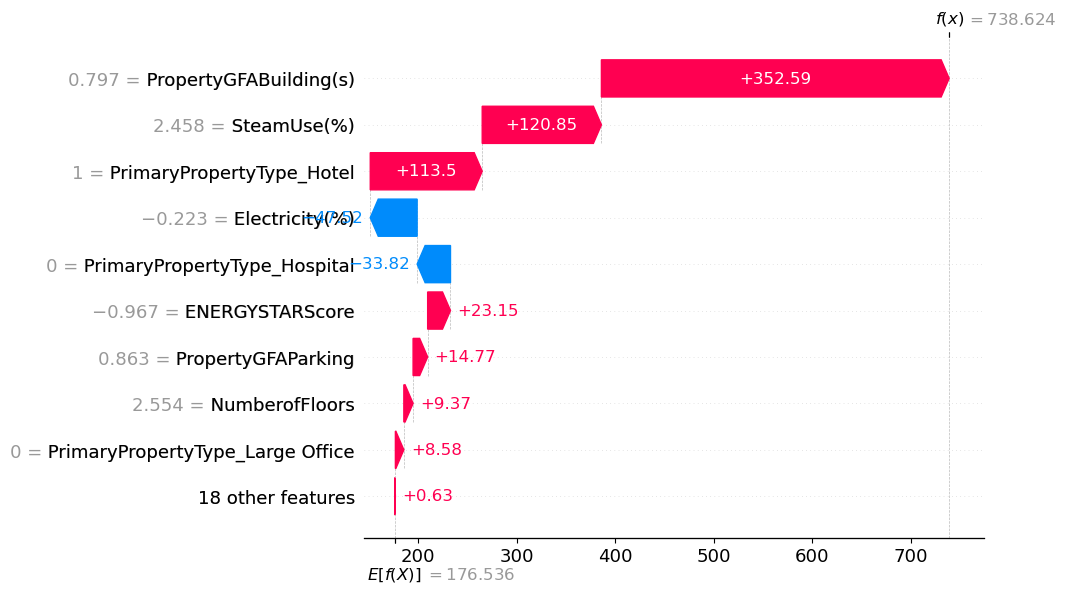

In [13]:
shap.plots.waterfall(shap_values[100], max_display=10)

Le moins que l'on puisse dire, c'est que la variable "EnergyStarScore" constitue une variable explicative importante dans notre modèle. D'après notre graphique, bien que son impact soit moins prononcé que les variables "PropertyGFABuildings(s)" ou "PrimaryPropertyType_Hospital" et explique à contrario assez peu la valeurs prédites considérées comme abérrantes par leurs chiffres élevés, il s'agit ni plus ni moins de la 5ème variable la plus influente de notre jeu de données. Sur un ensemble de pas moins de 27 variables explicatives, il est clair que l'importance de l'Energy Star Score est non-négligeable.

Nous allons par ailleurs pouvoir confirmer cela en conclusion de notre partie en comparant les indices de performances de notre même modèle, comprenant le même nombre d'individus, mais cette fois-ici en n'incluant pas la variable "EnergyStarScore" dans les calculs : 

In [14]:
X2 = energy.drop(columns=['TotalGHGEmissions','LargestPropertyUseType','PropertyGFATotal','LargestPropertyUseTypeGFA',
               'SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType',
               'ThirdLargestPropertyUseTypeGFA','SiteEnergyUseWN(kBtu)','ENERGYSTARScore'])

elements = [col for col in X2.columns if X2[col].dtype != object]

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, elements),
                                               ('cat', categorical_transformer, ['PrimaryPropertyType'])])

clf = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X2, y, test_size=0.2, random_state=50)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("R² =", r2_score(y_test, y_pred))
print("MAE =", mean_absolute_error(y_test, y_pred))
print("RMSE =", mean_squared_error(y_test, y_pred, squared=False))

R² = 0.10894207903547415
MAE = 143.9495760314131
RMSE = 1144.5185757078525


D'un R² de 0.14 à un R² d'environ 0.11, ainsi que d'une différence de RMSE d'environ 24, nous avons ici la confirmation que l'ajout de l'Energie Star Score dans nos algorithmes constitue un plus dans la performance du modèle. Ce dernier est donc davantage capable de se débrouiller avec que sans.

A ce stade de notre étude, nous disposons d'un modèle de prédiction optimisé et avons connaissance de l'importance du feature "Energy Star Score" dans l'efficacité des prédictions. Notre dernière étape avant la conclusion de ce rapport réside donc dans l'amélioration du feature engineering.

# IV. Amélioration du Feature Engineering<a name=5 ></a>

Nous allons ainsi tenter une piste d'amélioration qui consiste à la création de nouveaux features qui peuvent potentiellement se substituer à certains car considérés comme des sources plus importantes d'informations pour la prédiction de nos variables cibles.

Dans ce contexte, nous nous sommes intéressés de près aux usages multiples que l'on peut observer dans la plupart des bâtiments étudiés. Grâce aux variables "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseTypeGFA" ainsi que leurs GFA correspondants, il est possible de calculer le ratio des 3 activités principales d'un bâtiment. Nous avions vu précédemment que la nature des activités des bâtiments contribuaient significativement aux quantité d'émission de gaz à effet de serre. Ainsi, si nous sommes dans la capacité de mesurer l'importance de chaque activité au sein de chaque bâtiment, nous aurons accès à des valeurs plus proches de la réalité et donc plus à même de donner des résultats de prédiction corrects, du moins en théorie, là où jusqu'à maintenant la quantification de ces paramètres d'ordre qualitatif demeurait exclusivement binaire.

Le code qui va suivre constitue donc une tentative d'amélioration via une deuxième série de nettoyage et de traitement de données. Nous en jugerons ensuite de la pertinence en fonction des chiffres affichées dans les indices de performance de notre nouvel algorithme : 

In [15]:
parking = pretreatment(Building_Energy_Benchmarking).loc[pretreatment(Building_Energy_Benchmarking)['LargestPropertyUseType']\
                                                         =="Parking"]
parking = parking.loc[parking['LargestPropertyUseTypeGFA']!=parking['PropertyGFAParking']]

df = pretreatment(Building_Energy_Benchmarking).drop(parking.index)

df['LargestPropertyUseTypeGFA'] = df['LargestPropertyUseTypeGFA'].fillna(0)
df['SecondLargestPropertyUseTypeGFA'] = df['SecondLargestPropertyUseTypeGFA'].fillna(0)
df['ThirdLargestPropertyUseTypeGFA'] = df['ThirdLargestPropertyUseTypeGFA'].fillna(0)

df['Total(%)'] = (df['LargestPropertyUseTypeGFA']/df['PropertyGFATotal'])+(df['SecondLargestPropertyUseTypeGFA']\
/df['PropertyGFATotal'])+(df['ThirdLargestPropertyUseTypeGFA']/df['PropertyGFATotal'])

Q1 = df['Total(%)'].quantile(0.15)
Q3 = df['Total(%)'].quantile(0.85)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['Total(%)'] < lower_bound) | (df['Total(%)'] > upper_bound)]

df = df.loc[~df.index.isin(outliers.index)]

list_selected = ['College/University','Distribution Center','Hospital (General Medical & Surgical)','Hotel','K-12 School',
                 'Laboratory','Medical Office','Non-Refrigerated Warehouse','Office','Parking','Refrigerated Warehouse',
                 'Residence Hall/Dormitory','Supermarket/Grocery Store','Worship Facility']

def compute_ratio_type(row):
    if 'Use - Other' not in row:
        row['Use - Other'] = 0
    if row.LargestPropertyUseType in list_selected:
        row[f'Use - {row.LargestPropertyUseType}'] = row['LargestPropertyUseTypeGFA']/row['PropertyGFATotal']
    elif (row.LargestPropertyUseType not in list_selected)&(row.LargestPropertyUseType != None):
        row['Use - Other'] += row['LargestPropertyUseTypeGFA']/row['PropertyGFATotal']
    if row.SecondLargestPropertyUseType in list_selected:
        row[f'Use - {row.SecondLargestPropertyUseType}'] = row['SecondLargestPropertyUseTypeGFA']/row['PropertyGFATotal']
    elif (row.SecondLargestPropertyUseType not in list_selected)&(row.SecondLargestPropertyUseType != None):
        row['Use - Other'] += row['SecondLargestPropertyUseTypeGFA']/row['PropertyGFATotal']
    if row.ThirdLargestPropertyUseType in list_selected:
        row[f'Use - {row.ThirdLargestPropertyUseType}'] = row['ThirdLargestPropertyUseTypeGFA']/row['PropertyGFATotal']
    elif (row.ThirdLargestPropertyUseType not in list_selected)&(row.ThirdLargestPropertyUseType != None):
        row['Use - Other'] += row['ThirdLargestPropertyUseTypeGFA']/row['PropertyGFATotal']
    return row

df = df.apply(compute_ratio_type, axis=1)
df = df.fillna(0)

df.drop(columns=['ENERGYSTARScore','LargestPropertyUseType','LargestPropertyUseTypeGFA',
                 'PropertyGFAParking','SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA',
                 'ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA'], inplace=True)

y = df['TotalGHGEmissions']
X = df.drop(columns=['TotalGHGEmissions','SiteEnergyUseWN(kBtu)'])

elements = [col for col in X.columns if X[col].dtype != object]

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, elements),
                                               ('cat', categorical_transformer, ['PrimaryPropertyType'])])

clf = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=50)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("R² =", r2_score(y_test, y_pred))
print("MAE =", mean_absolute_error(y_test, y_pred))
print("RMSE =", mean_squared_error(y_test, y_pred, squared=False))

R² = -0.06105822271086936
MAE = 107.4003008504712
RMSE = 476.2641921325479


A l'évidence, notre tentative d'amélioration du feature engineering est un échec. Nous allons donc en rester là dans cette partie et passer directement à la conclusion de ce rapport.

# V. Conclusion<a name=6 ></a>

D'après nos analyses et nos différentes simulations, il nous semble le plus judicieux d'opter pour un modèle de Gradient Boosting Regression. En effet, grâce à un paramétrage optimisé, ce modèle de prédiction est capable de nous prédire des valeurs avec un niveau d'exactitude atteignant presque les 60%. De plus, la racine carrée de la moyenne des erreurs quadratiques est amoindrie si l'on compare les chiffres des différents algorithmes.

Cependant, ce RMSE demeure considérablement élevé lorsqu'il est mis en parallèle avec l'ensemble des valeurs réelles de notre variable cible. L'explication de ce phénomène provient du fait qu'il existerait à Seattle, selon nos observations, des bâtiments dont la quantité d'émission de gaz à effet de serre est anormalement élevée compte tenu des caractéristiques qui les définissent. Nous avions vu précédemment que l'existence de ces bâtiments était, d'un point de vue métier, tout à fait plausible et c'est pourquoi nous ne pouvions en aucun les retirer de notre dataset de départ. Il n'en demeure pas moins qu'elles tendent à altérer le niveau de performance de nos algorithmes et c'est l'enjeu de nos futures prédictions repose sur la prise en compte et le traitement adéquat de ces tendances d'ordre exceptionnel.